In [54]:
# Lae alati kõige värskemad Eleringi tegeliku tarbimise andmed (tunnipõhiselt) ja salvesta CSV koos veakontrolliga
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
from pathlib import Path

today = datetime.now(timezone.utc).date()
start_date = today - timedelta(days=3)
end_date = today

# Kasuta õiget CSV API endpointi
url = (
    "https://dashboard.elering.ee/api/system/with-plan/csv?"
    f"start={start_date}T00:00:00Z&end={end_date}T23:00:00Z&fields=consumption"
)
response = requests.get(url)

# Salvesta 'scripts' kausta dünaamilise nimega
actuals_path = Path("scripts") / f"elering_actual_from_{start_date:%Y%m%d}.csv"

if response.status_code == 200:
    # Loeme CSV otse vastusest, kasutades õiget eraldajat
    from io import StringIO
    df = pd.read_csv(StringIO(response.text), sep=';', encoding='utf-8')
    actuals_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(actuals_path, index=False, sep=';', encoding='utf-8')
    print(f"Andmed laetud: {actuals_path}")
else:
    print(f"API päring ebaõnnestus! HTTP kood: {response.status_code}, sisu: {response.text}\nAndmeid ei salvestatud.")

Andmed laetud: scripts\elering_actual_from_20250920.csv


In [55]:
# Kontrolli, kas tegeliku tarbimise CSV-fail eksisteerib enne lugemist
import os
from pathlib import Path

actuals_path = Path("scripts") / f"elering_actual_from_{start_date:%Y%m%d}.csv"
if not actuals_path.is_file():
    raise FileNotFoundError(f"Tarbimise CSV-fail puudub: {actuals_path}. Käivita esmalt andmete allalaadimise plokk!")

In [56]:
# Eleringi forecasti ja tegeliku tarbimise võrdlus, viga ja protsent
import pandas as pd
import os
from pathlib import Path
import csv
import pytz

# Kasuta ABSOLUUTSET kausta forecast failide jaoks (fallback: suhteline scripts/output)
ABS_BASE = Path(r"C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast")
OUT_DIR_ABS = ABS_BASE / "scripts" / "output"
OUT_DIR = OUT_DIR_ABS if OUT_DIR_ABS.exists() else (Path("scripts") / "output")
print("Forecast OUT_DIR:", OUT_DIR.resolve())

# Leia automaatselt forecast CSV-d kaustast scripts/output
forecast_files = sorted(OUT_DIR.glob("forecast_consumption_hourly_next7_tallinn_*.csv"))
if not forecast_files:
    raise FileNotFoundError(f"Ei leitud forecast CSV-sid kaustast: {OUT_DIR}")
forecast_path = forecast_files[-1]
print("Esialgne forecast:", forecast_path.name)

# --- Robusne CSV lugemine: tuvastab eraldaja/keelekodeeringu ja decimali ---
def read_csv_robust(path: Path) -> pd.DataFrame:
    encodings = ["utf-8", "cp1257", "latin1"]
    delimiters = [",", ";", "\t", "|"]
    decimals = [",", "."]

    raw = None
    try:
        with open(path, "rb") as f:
            raw = f.read(4096)
    except Exception:
        raw = None

    for enc in encodings:
        sample = None
        if raw is not None:
            try:
                sample = raw.decode(enc, errors="strict")
            except Exception:
                sample = None
        snif_sep = None
        if sample:
            try:
                dialect = csv.Sniffer().sniff(sample, delimiters=delimiters)
                snif_sep = dialect.delimiter
            except Exception:
                header = sample.splitlines()[0] if sample else ""
                snif_sep = ";" if ";" in header and header.count(";") >= header.count(",") else ","
        for sep in ([snif_sep] if snif_sep else delimiters):
            for dec in decimals:
                try:
                    df = pd.read_csv(path, sep=sep, encoding=enc, decimal=dec, skipinitialspace=True)
                except Exception:
                    continue
                if len(df.columns) == 1 and ("," in df.columns[0] or ";" in df.columns[0]):
                    continue
                return df
    return pd.read_csv(path)


def to_utc_naive(series: pd.Series) -> pd.Series:
    s = series
    # Kui tz-aware, konverteeri UTC-sse; kui tz-naive, lokaalista Tallinna ajaks
    if hasattr(s.dt, "tz") and s.dt.tz is not None:
        s = s.dt.tz_convert("UTC").dt.floor("h").dt.tz_localize(None)
    else:
        # tz-naive -> eelda kohalik Tallinna aeg
        s = s.dt.tz_localize("Europe/Tallinn", nonexistent="shift_forward", ambiguous="NaT")
        s = s.dt.tz_convert("UTC").dt.floor("h").dt.tz_localize(None)
    return s


def build_datetime_hour(df: pd.DataFrame) -> pd.Series:
    # 1) olemasolev datetime_hour
    if "datetime_hour" in df.columns:
        s = pd.to_datetime(df["datetime_hour"], errors="coerce")
        return to_utc_naive(s)
    # 2) datetime_local
    if "datetime_local" in df.columns:
        s = pd.to_datetime(df["datetime_local"], errors="coerce")
        return to_utc_naive(s)
    # 3) date_local + hour_local
    if "date_local" in df.columns and "hour_local" in df.columns:
        d = pd.to_datetime(df["date_local"], errors="coerce")
        h = pd.to_numeric(df["hour_local"], errors="coerce").fillna(0).astype(int)
        s = d + pd.to_timedelta(h, unit="h")
        return to_utc_naive(s)
    # 4) timestamp sekundites
    if "timestamp" in df.columns:
        s = pd.to_datetime(pd.to_numeric(df["timestamp"], errors="coerce"), unit="s", utc=True)
        return s.dt.floor("h").dt.tz_localize(None)
    raise ValueError(f"Forecast failis puudub sobiv kuupäeva/tunni veerg! Leitud veerud: {df.columns.tolist()}")

# --- Loe ACTUAL esmalt, et teada, kui kaugele actual olemas ---
actuals_path = Path("scripts") / f"elering_actual_from_{start_date:%Y%m%d}.csv"
df_actual = pd.read_csv(actuals_path, sep=';', decimal=',', skipinitialspace=True, encoding='utf-8')
if 'timestamp' in df_actual.columns and 'consumption' in df_actual.columns:
    df_actual['datetime_hour'] = pd.to_datetime(df_actual['timestamp'], unit='s', utc=True).dt.floor('h')
    df_actual['Tarbimine'] = pd.to_numeric(df_actual['consumption'], errors='coerce')
elif 'Ajatempel (UTC)' in df_actual.columns and 'Tarbimine' in df_actual.columns:
    df_actual['datetime_hour'] = pd.to_datetime(df_actual['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.floor('h')
    df_actual['Tarbimine'] = (
        df_actual['Tarbimine']
        .astype(str)
        .str.replace('"', '')
        .str.replace(',', '.')
        .str.strip()
    )
    df_actual['Tarbimine'] = pd.to_numeric(df_actual['Tarbimine'], errors='coerce')
else:
    raise ValueError(f"CSV failis puuduvad vajalikud veerud! Leitud veerud: {df_actual.columns.tolist()}")
# Eemalda timezone'id
if hasattr(df_actual['datetime_hour'].dt, 'tz'):
    df_actual['datetime_hour'] = df_actual['datetime_hour'].dt.tz_localize(None)
actual_max = df_actual['datetime_hour'].max()

# --- VALI forecast, millel on >=24 kattuvat tundi actualiga ---
def pick_forecast_with_overlap(files, actual_max_dt, max_check=12):
    """Tagasta esimene (uusimast alates) forecasti fail, millel on vähemalt 24 tundi <= actual_max_dt."""
    check_list = list(files)[-max_check:][::-1]  # alusta värskemast, vaata kuni max_check faili
    for p in check_list:
        try:
            tmp = read_csv_robust(p)
            if 'consumption_hourly' not in tmp.columns:
                continue
            tmp['consumption_hourly'] = (
                tmp['consumption_hourly'].astype(str)
                .str.replace('"','', regex=False)
                .str.replace(' ','', regex=False)
                .str.replace(',','.', regex=False)
            )
            tmp['consumption_hourly'] = pd.to_numeric(tmp['consumption_hourly'], errors='coerce')
            tmp['datetime_hour'] = build_datetime_hour(tmp)
            if hasattr(tmp['datetime_hour'].dt, 'tz'):
                tmp['datetime_hour'] = tmp['datetime_hour'].dt.tz_localize(None)
            overlap = (tmp['datetime_hour'] <= actual_max_dt) & tmp['consumption_hourly'].notna()
            if int(overlap.sum()) >= 24:
                return p
        except Exception as e:
            print(f"Hoiatus: ei saanud hinnata {p.name}: {e}")
    return files[-1]

chosen_forecast_path = pick_forecast_with_overlap(forecast_files, actual_max)
if chosen_forecast_path != forecast_path:
    forecast_path = chosen_forecast_path
    print("Kohandatud forecast valik (>=24h kattuv actualiga):", forecast_path.name)
else:
    print("Jääb esialgne forecast fail kasutusse.")

# --- Loe lõplik forecast ---
df_forecast = read_csv_robust(forecast_path)
if "consumption_hourly" in df_forecast.columns:
    df_forecast["consumption_hourly"] = (
        df_forecast["consumption_hourly"].astype(str)
        .str.replace('"', "", regex=False)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    df_forecast["consumption_hourly"] = pd.to_numeric(df_forecast["consumption_hourly"], errors="coerce")
else:
    raise ValueError("Forecast failis puudub veerg 'consumption_hourly'.")

df_forecast["datetime_hour"] = build_datetime_hour(df_forecast)
if hasattr(df_forecast['datetime_hour'].dt, 'tz'):
    df_forecast['datetime_hour'] = df_forecast['datetime_hour'].dt.tz_localize(None)

# Merge ja vead — hoia KÕIK meie forecasti tunnid (right-join)
df_merge = pd.merge(df_actual, df_forecast, on='datetime_hour', how='right', suffixes=('_actual', '_forecast'))

# --- Lisa Eleringi forecast ja arvutused ---
elering_forecast_path = Path('scripts') / 'elering_forecast_from_{:%Y%m%d}.csv'.format(df_actual['datetime_hour'].dt.date.min())
if elering_forecast_path.is_file():
    df_el_forecast = pd.read_csv(elering_forecast_path, sep=';', encoding='utf-8')
    df_el_forecast['datetime_hour'] = pd.to_datetime(df_el_forecast['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.floor('h')
    if 'Planeeritud tarbimine' in df_el_forecast.columns:
        df_el_forecast['elering_forecast'] = (
            df_el_forecast['Planeeritud tarbimine']
            .astype(str)
            .str.replace('"', '')
            .str.replace(',', '.')
            .str.strip()
        )
        df_el_forecast['elering_forecast'] = pd.to_numeric(df_el_forecast['elering_forecast'], errors='coerce')
        if hasattr(df_el_forecast['datetime_hour'].dt, 'tz'):
            df_el_forecast['datetime_hour'] = df_el_forecast['datetime_hour'].dt.tz_localize(None)
        df_merge = pd.merge(df_merge, df_el_forecast[['datetime_hour', 'elering_forecast']], on='datetime_hour', how='left')
    else:
        print(f"Eleringi forecasti failis puudub veerg 'Planeeritud tarbimine'. Jätkan ilma forecasti arvutusteta.")
else:
    print(f"Eleringi forecasti fail puudub: {elering_forecast_path}. Jätkan ilma nende veergudeta.")

# Arvuta vead (võivad olla NaN kui võrdlus puudub)
df_merge['viga'] = df_merge['Tarbimine'] - df_merge['consumption_hourly']
df_merge['viga_protsent'] = 100 * df_merge['viga'] / df_merge['Tarbimine']
if 'elering_forecast' in df_merge.columns:
    df_merge['viga_vs_elering_forecast'] = df_merge['consumption_hourly'] - df_merge['elering_forecast']
    df_merge['viga_vs_elering_forecast_protsent'] = 100 * df_merge['viga_vs_elering_forecast'] / df_merge['elering_forecast']
    df_merge['viga_actual_vs_elering_forecast'] = df_merge['Tarbimine'] - df_merge['elering_forecast']
    df_merge['viga_actual_vs_elering_forecast_protsent'] = 100 * df_merge['viga_actual_vs_elering_forecast'] / df_merge['elering_forecast']

# --- NA käsitlus: põhjused + tuumikveerud kohustuslikud ---
ef_series = df_merge['elering_forecast'] if 'elering_forecast' in df_merge.columns else pd.Series([None] * len(df_merge))
df_merge['na_reason'] = [
    ';'.join([r for r in [
        'missing_actual' if pd.isna(a) else '',
        'missing_our_forecast' if pd.isna(f) else '',
        'missing_elering_forecast' if pd.isna(ef) else ''
    ] if r])
    for a, f, ef in zip(df_merge['Tarbimine'], df_merge['consumption_hourly'], ef_series)
]

# Ära eemalda tuleviku tunde — hoia kõik meie forecastiga read; eemalda ainult, kui meie forecast puudub
before = len(df_merge)
df_merge = df_merge.dropna(subset=['consumption_hourly'])
after = len(df_merge)
if before != after:
    print(f"Eemaldasin {before - after} rida, kus puudus 'consumption_hourly' (meie forecast).")
# Märgista tühjad põhjused "OK"-ga
if 'na_reason' in df_merge.columns:
    df_merge['na_reason'] = df_merge['na_reason'].replace('', 'OK')

# --- FILTREERI KOHE SOOVITUD VEERUD ---
columns_to_keep = [
    "Ajatempel (UTC)",
    "Kuupäev (Eesti aeg)",
    "Tarbimine",
    "weekday",
    "hour_local",
    "consumption_hourly",
    "season",
    "is_weekend",
    "is_holiday",
    "EE_avg_temp_C",
    "bias_key",
    "bias_factor",
    "yhat_base",
    "yhat_consumption",
    "viga",
    "viga_protsent",
    "elering_forecast",
    "viga_vs_elering_forecast",
    "viga_vs_elering_forecast_protsent",
    "viga_actual_vs_elering_forecast",
    "viga_actual_vs_elering_forecast_protsent",
    "na_reason"
]
columns_present = [col for col in columns_to_keep if col in df_merge.columns]
filtered = df_merge[columns_present]

# Ühtne salvestuskoht ja eraldaja
out_path = Path("scripts") / "forecast_vs_actual_comparison_hourly.csv"
filtered.to_csv(out_path, sep=";", index=False, encoding="utf-8")
print(f"Salvestatud: {out_path}")
print(filtered.head())

Forecast OUT_DIR: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output
Esialgne forecast: forecast_consumption_hourly_next7_tallinn_20250923_20250929.csv
Kohandatud forecast valik (>=24h kattuv actualiga): forecast_consumption_hourly_next7_tallinn_20250920_20250926.csv
Salvestatud: scripts\forecast_vs_actual_comparison_hourly.csv
   Ajatempel (UTC) Kuupäev (Eesti aeg)  Tarbimine   weekday  hour_local  \
0              NaN                 NaN        NaN  Saturday           0   
1              NaN                 NaN        NaN  Saturday           1   
2              NaN                 NaN        NaN  Saturday           2   
3     1.758326e+09    20.09.2025 03:00      686.1  Saturday           3   
4     1.758330e+09    20.09.2025 04:00      682.6  Saturday           4   

   consumption_hourly season  is_weekend  is_holiday EE_avg_temp_C  ...  \
0          677.538448  sügis        True       False         15.17  ...   
1          

## Lisa Eleringi forecast võrdlusesse
See plokk laeb alla Eleringi enda forecasti (prognoosi) API-st, loeb selle sisse, liidab comparison-tabelisse ja arvutab vead nii meie forecasti kui Eleringi forecasti suhtes.

In [57]:
# Lae alla Eleringi forecast (prognoos) API-st
import os
os.makedirs('scripts', exist_ok=True)
elering_forecast_url = (
    f'https://dashboard.elering.ee/api/system/with-plan/csv?start={start_date}T00:00:00Z'
    f'&end={end_date}T23:00:00Z&fields=consumption&fields=consumptionPlan'
    )
elering_forecast_path = 'scripts/elering_forecast_from_{:%Y%m%d}.csv'.format(start_date)
resp_forecast = requests.get(elering_forecast_url)
if resp_forecast.status_code == 200:
    from io import StringIO
    df_el_forecast = pd.read_csv(StringIO(resp_forecast.text), sep=';', encoding='utf-8')
    df_el_forecast.to_csv(elering_forecast_path, index=False, sep=';', encoding='utf-8')
    print(f'Eleringi forecast andmed laetud: {elering_forecast_path}')
    print('Veerud:', df_el_forecast.columns.tolist())
else:
    raise RuntimeError(f'Eleringi forecast API päring ebaõnnestus! HTTP kood: {resp_forecast.status_code}, sisu: {resp_forecast.text}')

# Loe Eleringi forecast fail sisse
df_el_forecast = pd.read_csv(elering_forecast_path, sep=';', encoding='utf-8')
print('Veerud Eleringi forecast failis (lugemisel):', df_el_forecast.columns.tolist())

# Lisa Eleringi forecast merge-tabelisse ja arvuta vead (ÄRA kirjuta comparison-faili üle; salvesta eraldi enriched)
if 'Planeeritud tarbimine' in df_el_forecast.columns:
    df_el_forecast['datetime_hour'] = pd.to_datetime(df_el_forecast['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.floor('h')
    df_el_forecast['elering_forecast'] = (
        df_el_forecast['Planeeritud tarbimine']
        .astype(str)
        .str.replace('"', '')
        .str.replace(',', '.')
        .str.strip()
    )
    df_el_forecast['elering_forecast'] = pd.to_numeric(df_el_forecast['elering_forecast'], errors='coerce')
    # Eemalda timezone mõlemalt datetime_hour veerult enne merge'i
    if hasattr(df_merge['datetime_hour'].dt, 'tz'):
        df_merge['datetime_hour'] = df_merge['datetime_hour'].dt.tz_localize(None)
    if hasattr(df_el_forecast['datetime_hour'].dt, 'tz'):
        df_el_forecast['datetime_hour'] = df_el_forecast['datetime_hour'].dt.tz_localize(None)
    df_enriched = pd.merge(df_merge, df_el_forecast[['datetime_hour', 'elering_forecast']], on='datetime_hour', how='left')
    # Arvuta veerud ainult kui elering_forecast on olemas
    if 'elering_forecast' in df_enriched.columns:
        df_enriched['viga_vs_elering_forecast'] = df_enriched['consumption_hourly'] - df_enriched['elering_forecast']
        df_enriched['viga_vs_elering_forecast_protsent'] = 100 * df_enriched['viga_vs_elering_forecast'] / df_enriched['elering_forecast']
        df_enriched['viga_actual_vs_elering_forecast'] = df_enriched['Tarbimine'] - df_enriched['elering_forecast']
        df_enriched['viga_actual_vs_elering_forecast_protsent'] = 100 * df_enriched['viga_actual_vs_elering_forecast'] / df_enriched['elering_forecast']
    else:
        print("Hoiatus: 'elering_forecast' veerg puudub pärast merge'i, arvutusi ei tehta.")
else:
    print("Hoiatus: 'Planeeritud tarbimine' veerg puudub Eleringi forecast failis, forecasti arvutusi ei tehta.")

# Prindi esimesed read, kui võimalik
base_cols = ['datetime_hour', 'Tarbimine', 'consumption_hourly', 'elering_forecast', 'viga', 'viga_vs_elering_forecast', 'viga_actual_vs_elering_forecast']
cols_to_show = [col for col in base_cols if col in (df_enriched.columns if 'df_enriched' in locals() else df_merge.columns)]
print((df_enriched if 'df_enriched' in locals() else df_merge)[cols_to_show].head())

# Salvesta enriched variant eraldi failina, comparison alusfail jääb puutumata
output_path_enriched = 'scripts/forecast_vs_actual_comparison_hourly_enriched.csv'
(df_enriched if 'df_enriched' in locals() else df_merge).to_csv(output_path_enriched, sep=';', index=False, encoding='utf-8')
print(f'Võrdlustabel enriched salvestatud: {output_path_enriched}')

Eleringi forecast andmed laetud: scripts/elering_forecast_from_20250920.csv
Veerud: ['Ajatempel (UTC)', 'Kuupäev (Eesti aeg)', 'Tarbimine', 'Planeeritud tarbimine']
Veerud Eleringi forecast failis (lugemisel): ['Ajatempel (UTC)', 'Kuupäev (Eesti aeg)', 'Tarbimine', 'Planeeritud tarbimine']
Hoiatus: 'elering_forecast' veerg puudub pärast merge'i, arvutusi ei tehta.


KeyError: "['elering_forecast'] not in index"

In [ ]:
# Lisa Eleringi plaan actual-faili (tunnipõhine merge)
from pathlib import Path
actuals_path = Path("scripts") / f"elering_actual_from_{start_date:%Y%m%d}.csv"
actual_df = pd.read_csv(actuals_path, sep=';', encoding='utf-8')

# Lisa datetime_hour veerg actual_df
actual_df['datetime_hour'] = pd.to_datetime(actual_df['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.floor('h')

# Lisa datetime_hour veerg forecast_df (kui pole juba olemas)
df_el_forecast['datetime_hour'] = pd.to_datetime(df_el_forecast['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.floor('h')

# Lisa forecasti veerg actual_df-sse
actual_with_plan = pd.merge(actual_df, df_el_forecast[['datetime_hour', 'Planeeritud tarbimine']], on='datetime_hour', how='left')

# Salvestame uue faili
target = Path("scripts") / f"elering_actual_with_plan_from_{start_date:%Y%m%d}.csv"
actual_with_plan.to_csv(target, sep=';', index=False, encoding='utf-8')
print(f"Tegelik tarbimine koos Eleringi plaaniga salvestatud: {target}")

Tegelik tarbimine koos Eleringi plaaniga salvestatud: scripts\elering_actual_with_plan_from_20250920.csv


In [ ]:
# Diagnostika: prindi olemasolevad veerud ja ridade arv
import pandas as pd
input_path = "scripts/forecast_vs_actual_comparison_hourly.csv"
df = pd.read_csv(input_path, sep=";", encoding="utf-8")
print("Algfaili veerud:", list(df.columns))
print("Algfaili ridade arv:", len(df))
print("Esimesed read:")
print(df.head())
print("\nPuuduvate väärtuste arv igas veerus:")
print(df.isnull().sum())

# Täiendav selgitus: na_reason jaotus (miks väärtused võivad puududa)
if 'na_reason' in df.columns:
    print("\nna_reason jaotus (ridade arv põhjuse kaupa):")
    counts = df['na_reason'].fillna('OK').value_counts(dropna=False)
    print(counts)
    # Kui soovid detailsemat jaotust mitme põhjuse lõikes, lõhu ';' järgi
    exploded = df.assign(reason=df['na_reason'].fillna('OK').str.split(';')).explode('reason')
    exploded['reason'] = exploded['reason'].replace('', 'OK')
    print("\nna_reason (explode) jaotus üksikute siltide kaupa:")
    print(exploded['reason'].value_counts())

Algfaili veerud: ['Ajatempel (UTC)', 'Kuupäev (Eesti aeg)', 'Tarbimine', 'datetime_hour', 'datetime_local', 'weekday', 'hour_local', 'consumption_hourly', 'date_local', 'segment', 'season', 'is_weekend', 'is_holiday', 'month_num', 'EE_avg_temp_C', 'bias_key', 'bias_factor', 'yhat_base', 'yhat_consumption', 'elering_forecast_x', 'viga', 'viga_protsent', 'viga_vs_elering_forecast', 'viga_vs_elering_forecast_protsent', 'viga_actual_vs_elering_forecast', 'viga_actual_vs_elering_forecast_protsent', 'na_reason', 'elering_forecast_y']
Algfaili ridade arv: 168
Esimesed read:
   Ajatempel (UTC) Kuupäev (Eesti aeg)  Tarbimine        datetime_hour  \
0              NaN                 NaN        NaN  2025-09-19 21:00:00   
1              NaN                 NaN        NaN  2025-09-19 22:00:00   
2              NaN                 NaN        NaN  2025-09-19 23:00:00   
3     1.758326e+09    20.09.2025 03:00      686.1  2025-09-20 00:00:00   
4     1.758330e+09    20.09.2025 04:00      682.6  2025-

In [ ]:
# Abi: vali rangelt 24 tunni UTC aken (00:00–23:00)
import pandas as pd

def select_strict_utc_day_mask(dt, valid_mask=None, target_day_utc=None, prefer_latest=True):
    """
    Tagastab (mask, selected_day), mis piirab andmed ühele UTC päevale 00:00–23:00 TÄPSELT 24 kehtiva punktiga.

    Parameetrid:
    - dt: pandas Series kuupäev/kellaaegadega (naive UTC või tz-aware)
    - valid_mask: boole'i Series sama pikkusega; kui antud, loetakse päev kehtivaks ainult seal, kus valid_mask on True
    - target_day_utc: valikuline 'YYYY-MM-DD' või Timestamp; kui sellel päeval on 24 kehtivat punkti, kasutatakse seda
    - prefer_latest: kui kandidaate on mitu, vali viimane (True) või esimene (False)
    """
    s = pd.to_datetime(dt, errors='coerce')
    # Normaliseeri UTC-naive
    if getattr(s.dt, "tz", None) is not None:
        s = s.dt.tz_convert("UTC").dt.tz_localize(None)
    day = s.dt.floor("D")
    n = len(s)
    if n == 0:
        return pd.Series([False], index=pd.RangeIndex(0, 1)), None

    vm = valid_mask
    if vm is None:
        vm = s.notna()
    else:
        vm = vm & s.notna()

    def day_has_24(d):
        m = (day == d)
        return int(vm[m].sum()) == 24

    selected = None
    if target_day_utc is not None:
        try:
            td = pd.to_datetime(str(target_day_utc), utc=True).tz_convert(None).floor("D")
            if day_has_24(td):
                selected = td
        except Exception:
            selected = None

    if selected is None:
        # hinda päevi kehtivate punktide arvu järgi
        by_day = vm.groupby(day).sum()
        candidates = by_day[by_day == 24].index
        if len(candidates) > 0:
            selected = candidates.max() if prefer_latest else candidates.min()
        else:
            # puudub täpne 24 punkti päev – tagasta viimane päev (fallback)
            if len(day) == 0:
                return pd.Series([False]*n), None
            selected = day.max()

    start = selected
    end = selected + pd.Timedelta(hours=23)
    mask = (s >= start) & (s <= end)
    return mask, selected

## Visuaalsed kokkuvõtted (graafikud)
Allpool on iga väljund-CSV kohta sobiv graafiline ülevaade, et tulemustest oleks kohe visuaalselt arusaadav pilt:
- forecast_vs_actual_comparison_hourly.csv: ajarida (Tarbimine vs meie forecast vs Eleringi forecast), vead (%), hajuvusgraafik.
- elering_actual_from_*.csv: ajarida tegelikust tarbimisest.
- elering_forecast_from_*.csv: ajarida Eleringi plaanist.
- elering_actual_with_plan_from_*.csv: tegelik vs plaan samal graafikul.

Kõik pildid salvestatakse kausta `scripts/plots`.

Rakendatud range (scatter): UTC päev 2025-09-22 00:00–23:00; read=24


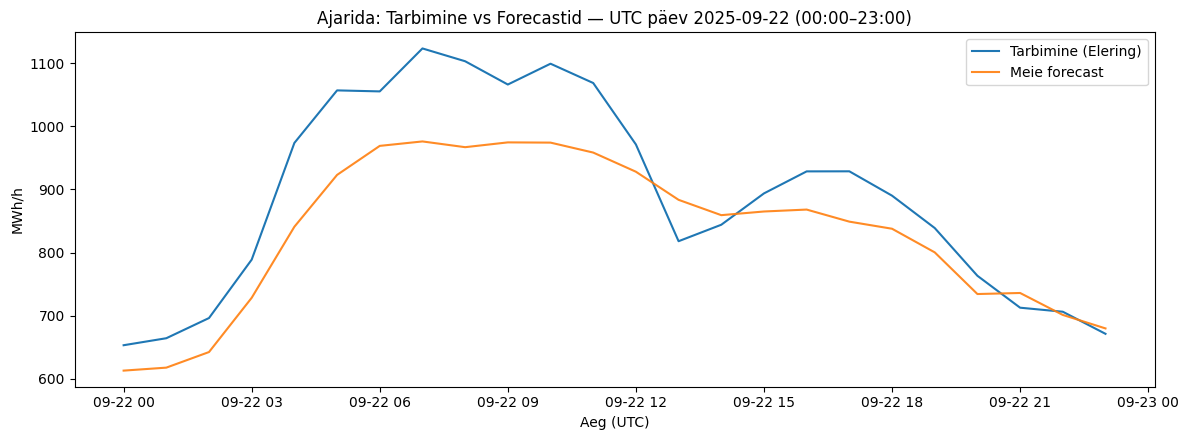

Salvestatud: scripts\plots\comparison_timeseries.png


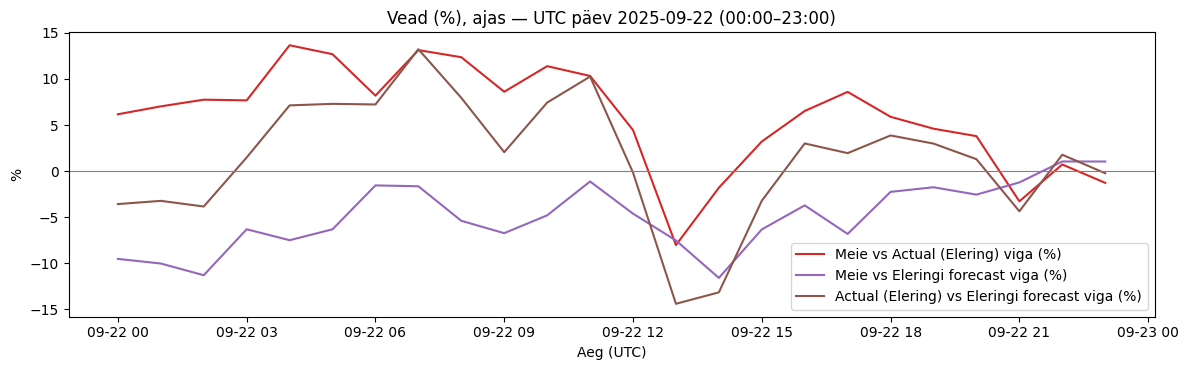

Salvestatud: scripts\plots\comparison_errors_pct.png


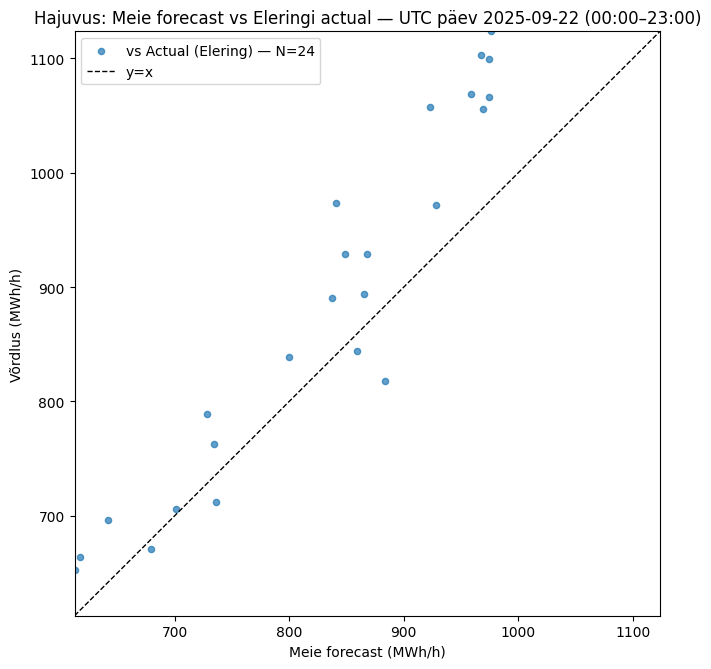

Salvestatud: scripts\plots\scatter_forecast_vs_actual_and_plan.png


In [ ]:
# Graafik 1: forecast_vs_actual_comparison_hourly.csv — ajarida + vead + kombineeritud hajuvus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PLOTS_DIR = Path("scripts") / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

comp_path = Path("scripts") / "forecast_vs_actual_comparison_hourly.csv"
if not comp_path.is_file():
    print(f"⏭️ Vahele: puudub {comp_path}")
else:
    df = pd.read_csv(comp_path, sep=';', encoding='utf-8')
    # Paranda võimalikud duplikaadid elering_forecast_x / elering_forecast_y -> elering_forecast
    if 'elering_forecast' not in df.columns and ('elering_forecast_x' in df.columns or 'elering_forecast_y' in df.columns):
        df['elering_forecast'] = df.get('elering_forecast_x')
        if 'elering_forecast_y' in df.columns:
            df['elering_forecast'] = df['elering_forecast'].combine_first(df['elering_forecast_y'])

    # Kasuta olemasolevat ajamärki; kui puudub, tuleta
    if 'datetime_hour' in df.columns:
        dt = pd.to_datetime(df['datetime_hour'], errors='coerce', utc=True).dt.tz_localize(None)
    elif 'Ajatempel (UTC)' in df.columns:
        dt = pd.to_datetime(pd.to_numeric(df['Ajatempel (UTC)'], errors='coerce'), unit='s', utc=True).dt.tz_localize(None)
    else:
        dt = pd.Series(range(len(df)))

    # Rangelt üks UTC päev hajuvuse jaoks: eelistus (mõlemal 24p) > (plaan 24p) > (actual 24p)
    STRICT_UTC_DAY = True
    TARGET_DAY_UTC = None  # nt '2025-09-22' kui soovid konkreetset päeva

    if STRICT_UTC_DAY and isinstance(dt, pd.Series) and getattr(dt, "dt", None) is not None:
        has_fore = 'consumption_hourly' in df.columns
        has_act = 'Tarbimine' in df.columns
        has_plan = 'elering_forecast' in df.columns
        fore_valid = pd.to_numeric(df['consumption_hourly'], errors='coerce').notna() if has_fore else pd.Series([False] * len(df))
        act_valid = pd.to_numeric(df['Tarbimine'], errors='coerce').notna() if has_act else pd.Series([False] * len(df))
        plan_valid = pd.to_numeric(df['elering_forecast'], errors='coerce').notna() if has_plan else pd.Series([False] * len(df))
        pair_act = fore_valid & act_valid
        pair_plan = fore_valid & plan_valid
        day = pd.to_datetime(dt, errors='coerce').dt.floor('D')
        chosen = None
        if TARGET_DAY_UTC is not None:
            try:
                td = pd.to_datetime(str(TARGET_DAY_UTC), utc=True).tz_convert(None).floor('D')
                if int(pair_act[day == td].sum()) == 24 or int(pair_plan[day == td].sum()) == 24:
                    chosen = td
            except Exception:
                chosen = None
        if chosen is None:
            by_act = pair_act.groupby(day).sum() if len(day) else pd.Series(dtype=float)
            by_plan = pair_plan.groupby(day).sum() if len(day) else pd.Series(dtype=float)
            full_act_days = set(by_act[by_act == 24].index) if len(by_act) else set()
            full_plan_days = set(by_plan[by_plan == 24].index) if len(by_plan) else set()
            both_full = sorted(full_act_days & full_plan_days)
            if both_full:
                chosen = max(both_full)
            elif full_plan_days:  # eelistame tänast plaani kui võimalik
                chosen = max(full_plan_days)
            elif full_act_days:
                chosen = max(full_act_days)
            else:
                chosen = None
        if chosen is not None:
            start = chosen
            end = chosen + pd.Timedelta(hours=23)
            m = (dt >= start) & (dt <= end)
            df = df.loc[m].copy()
            dt = dt.loc[m]
            print(f"Rakendatud range (scatter): UTC päev {pd.to_datetime(chosen).date()} 00:00–23:00; read={len(df)}")
        else:
            print("⚠️ Ei leitud 24-punktist UTC päeva ei actuali ega plaani jaoks; hajuvus näitab kogu valikut.")

    # Ajarida: Tarbimine vs meie forecast vs Eleringi forecast (kasutab sama akent kui hajuvus)
    plt.figure(figsize=(12,4.5))
    if 'Tarbimine' in df.columns:
        plt.plot(dt, df['Tarbimine'], label='Tarbimine (Elering)', color='#1f77b4')
    if 'consumption_hourly' in df.columns:
        plt.plot(dt, df['consumption_hourly'], label='Meie forecast', color='#ff7f0e', alpha=0.9)
    if 'elering_forecast' in df.columns:
        plt.plot(dt, df['elering_forecast'], label='Eleringi forecast', color='#2ca02c', alpha=0.7)
    # Lisa ajavahemik pealkirja
    title_day = None
    try:
        title_day = pd.to_datetime(dt.iloc[0]).floor('D').date() if len(dt) else None
    except Exception:
        title_day = None
    day_text = f" — UTC päev {title_day} (00:00–23:00)" if title_day is not None else ""
    plt.title('Ajarida: Tarbimine vs Forecastid' + day_text)
    plt.xlabel('Aeg (UTC)'); plt.ylabel('MWh/h'); plt.legend(); plt.tight_layout()
    out1 = PLOTS_DIR / 'comparison_timeseries.png'
    plt.savefig(out1, dpi=144); plt.show(); print('Salvestatud:', out1)

    # Vead protsentides ajas (kui olemas)
    if 'viga_protsent' in df.columns or 'viga_vs_elering_forecast_protsent' in df.columns or 'viga_actual_vs_elering_forecast_protsent' in df.columns:
        plt.figure(figsize=(12,3.8))
        if 'viga_protsent' in df.columns:
            plt.plot(dt, df['viga_protsent'], label='Meie vs Actual (Elering) viga (%)', color='#d62728')
        if 'viga_vs_elering_forecast_protsent' in df.columns:
            plt.plot(dt, df['viga_vs_elering_forecast_protsent'], label='Meie vs Eleringi forecast viga (%)', color='#9467bd')
        if 'viga_actual_vs_elering_forecast_protsent' in df.columns:
            plt.plot(dt, df['viga_actual_vs_elering_forecast_protsent'], label='Actual (Elering) vs Eleringi forecast viga (%)', color='#8c564b')
        plt.axhline(0, color='gray', lw=0.8)
        plt.title('Vead (%), ajas' + day_text)
        plt.xlabel('Aeg (UTC)'); plt.ylabel('%'); plt.legend(); plt.tight_layout()
        out2 = PLOTS_DIR / 'comparison_errors_pct.png'
        plt.savefig(out2, dpi=144); plt.show(); print('Salvestatud:', out2)

    # Kombineeritud hajuvus: Meie forecast vs Eleringi actual JA vs Eleringi plaan
    if 'consumption_hourly' in df.columns:
        x_for = pd.to_numeric(df['consumption_hourly'], errors='coerce')
        # Actual (Elering)
        has_actual = 'Tarbimine' in df.columns
        if has_actual:
            y_act = pd.to_numeric(df['Tarbimine'], errors='coerce')
            mask_act = x_for.notna() & y_act.notna()
            n_act = int(mask_act.sum())
        else:
            y_act = None
            mask_act = None
            n_act = 0
        # Eleringi plaan
        has_plan = 'elering_forecast' in df.columns
        if has_plan:
            y_plan = pd.to_numeric(df['elering_forecast'], errors='coerce')
            mask_plan = x_for.notna() & y_plan.notna()
            n_plan = int(mask_plan.sum())
        else:
            y_plan = None
            mask_plan = None
            n_plan = 0

        if n_act == 0 and n_plan == 0:
            print("⏭️ Vahele: hajuvus — puuduvad kattuvad punktid nii actuali kui plaani jaoks.")
        else:
            plt.figure(figsize=(6.8,6.8))
            mins = []
            maxs = []
            # Plot: forecast vs Eleringi actual
            if n_act > 0:
                x_a = x_for[mask_act]
                y_a = y_act[mask_act]
                plt.scatter(x_a, y_a, s=20, alpha=0.7, color='#1f77b4', label=f'vs Actual (Elering) — N={n_act}')
                mins += [x_a.min(), y_a.min()]
                maxs += [x_a.max(), y_a.max()]
            # Plot: forecast vs Eleringi plan
            if n_plan > 0:
                x_p = x_for[mask_plan]
                y_p = y_plan[mask_plan]
                plt.scatter(x_p, y_p, s=20, alpha=0.7, color='#9467bd', label=f'vs Eleringi forecast — N={n_plan}')
                mins += [x_p.min(), y_p.min()]
                maxs += [x_p.max(), y_p.max()]
            if mins and maxs:
                lo = float(np.nanmin(mins))
                hi = float(np.nanmax(maxs))
                plt.plot([lo, hi], [lo, hi], 'k--', lw=1, label='y=x')
                plt.xlim(lo, hi); plt.ylim(lo, hi)
            # Valmista pealkiri vastavalt sellele, millised seeriad on nähtaval, ja lisa ajavahemik
            if n_act > 0 and n_plan > 0:
                base_title = 'Hajuvus: Meie forecast vs Eleringi actual ja plaan'
            elif n_act > 0:
                base_title = 'Hajuvus: Meie forecast vs Eleringi actual'
            else:
                base_title = 'Hajuvus: Meie forecast vs Eleringi plaan'
            plt.title(base_title + day_text)
            plt.xlabel('Meie forecast (MWh/h)')
            plt.ylabel('Võrdlus (MWh/h)')
            plt.legend(); plt.tight_layout()
            out_combined = PLOTS_DIR / 'scatter_forecast_vs_actual_and_plan.png'
            plt.savefig(out_combined, dpi=144); plt.show(); print('Salvestatud:', out_combined)
    else:
        print("⏭️ Vahele: hajuvus — veerg 'consumption_hourly' puudub.")

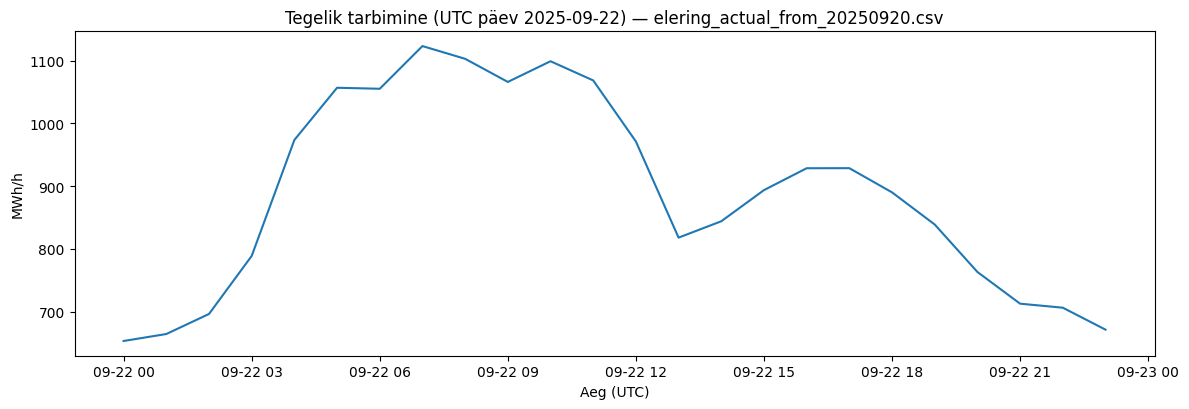

Salvestatud: scripts\plots\actual_timeseries.png


In [ ]:
# Graafik 2: elering_actual_from_*.csv — tegelik tarbimine ajas (24 punkti 00–23 UTC)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PLOTS_DIR = Path("scripts") / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Leia viimane actual-fail
actual_files = sorted(Path("scripts").glob("elering_actual_from_*.csv"))
if not actual_files:
    print("⏭️ Vahele: actual-fail puudub")
else:
    apath = actual_files[-1]
    adf = pd.read_csv(apath, sep=';', encoding='utf-8')

    # Tuvasta ajaveerg ja tarbimise veerg, toeta mõlemat formaati
    dt = None
    y = None

    if 'Ajatempel (UTC)' in adf.columns:
        # Eemalda võimalikud jutumärgid, tühikud jne ja teisenda sekunditeks
        ts = pd.to_numeric(adf['Ajatempel (UTC)'].astype(str).str.replace('"', '', regex=False).str.strip(), errors='coerce')
        dt = pd.to_datetime(ts, unit='s', utc=True).dt.tz_localize(None)
    elif 'timestamp' in adf.columns:
        ts = pd.to_numeric(adf['timestamp'], errors='coerce')
        dt = pd.to_datetime(ts, unit='s', utc=True).dt.tz_localize(None)

    if 'Tarbimine' in adf.columns:
        # Normaliseeri komakohad ja jutumärgid
        y = pd.to_numeric(adf['Tarbimine'].astype(str)
                          .str.replace('"', '', regex=False)
                          .str.replace(' ', '', regex=False)
                          .str.replace(',', '.', regex=False)
                          .str.strip(),
                          errors='coerce')
    elif 'consumption' in adf.columns:
        y = pd.to_numeric(adf['consumption'], errors='coerce')

    if dt is None or y is None:
        print(f"⏭️ Vahele: {apath.name} ei sisalda tuvastatavaid veerge (leiti veerud: {list(adf.columns)})")
    else:
        mask = dt.notna() & y.notna()
        dt = dt[mask]
        y = y[mask]

        if len(dt) == 0:
            print(f"⏭️ Vahele: {apath.name} — pärast puhastust puuduvad kehtivad punktid (NaN). Kontrolli veeruväärtusi.")
        else:
            # Kasuta ühist range selektorit: täpselt 00–23 UTC, N=24 kui võimalik
            vm = y.notna()
            m, sel_day = select_strict_utc_day_mask(dt, valid_mask=vm, target_day_utc=None, prefer_latest=True)
            n_valid = int(vm[m].sum())
            if n_valid != 24:
                print("⏭️ Vahele: ei leitud täis UTC päeva 24 punktiga tegelike andmete jaoks.")
            else:
                dt_w = dt[m]
                y_w = y[m]
                plt.figure(figsize=(12,4.2))
                plt.plot(dt_w, y_w, label='Tarbimine', color='#1f77b4')
                title_day = pd.to_datetime(sel_day).date() if sel_day is not None else 'valik'
                plt.title(f'Tegelik tarbimine (UTC päev {title_day}) — {apath.name}')
                plt.xlabel('Aeg (UTC)'); plt.ylabel('MWh/h'); plt.tight_layout()
                outp = PLOTS_DIR / 'actual_timeseries.png'
                plt.savefig(outp, dpi=144); plt.show(); print('Salvestatud:', outp)

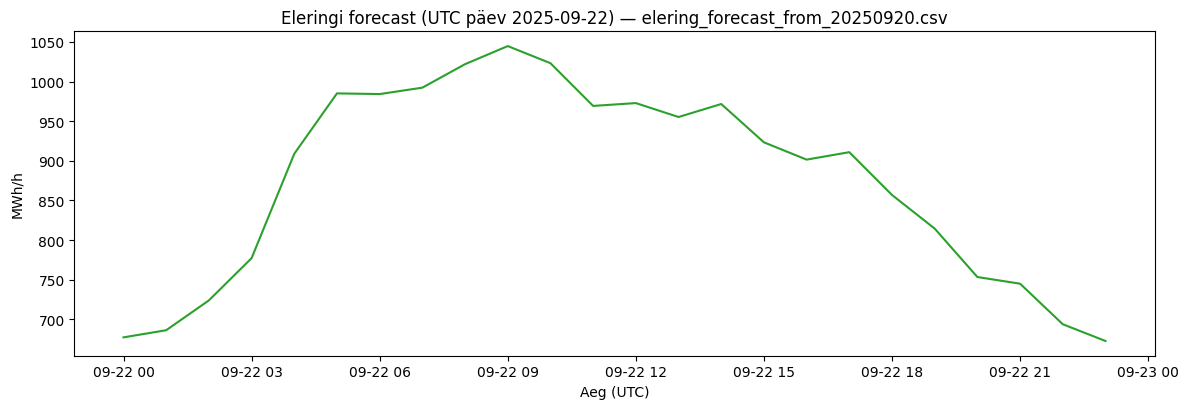

Salvestatud: scripts\plots\elering_plan_timeseries.png


In [ ]:
# Graafik 3: elering_forecast_from_*.csv — Eleringi plaan ajas (24 punkti 00–23 UTC, kui võimalik)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PLOTS_DIR = Path("scripts") / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

fc_files = sorted(Path("scripts").glob("elering_forecast_from_*.csv"))
if not fc_files:
    print("⏭️ Vahele: Eleringi forecasti fail puudub")
else:
    fpath = fc_files[-1]
    fdf = pd.read_csv(fpath, sep=';', encoding='utf-8')
    if 'Ajatempel (UTC)' in fdf.columns and 'Planeeritud tarbimine' in fdf.columns:
        dt = pd.to_datetime(fdf['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.tz_localize(None)
        y = pd.to_numeric(fdf['Planeeritud tarbimine'].astype(str).str.replace('"','').str.replace(',','.'), errors='coerce')
        mask = dt.notna() & y.notna()
        dt = dt[mask]
        y = y[mask]

        # Range filter: vali rangelt 00–23 UTC, N=24 kui võimalik
        vm = y.notna()
        m, sel_day = select_strict_utc_day_mask(dt, valid_mask=vm, target_day_utc=None, prefer_latest=True)
        n_valid = int(vm[m].sum())
        if n_valid != 24:
            print("⏭️ Vahele: ei leitud täis UTC päeva 24 punktiga Eleringi plaani jaoks.")
        else:
            dt_w = dt[m]
            y_w = y[m]

            plt.figure(figsize=(12,4.2))
            plt.plot(dt_w, y_w, label='Eleringi plaan', color='#2ca02c')
            title_day = pd.to_datetime(sel_day).date() if sel_day is not None else 'valik'
            plt.title(f'Eleringi forecast (UTC päev {title_day}) — {fpath.name}')
            plt.xlabel('Aeg (UTC)'); plt.ylabel('MWh/h'); plt.tight_layout()
            outp = PLOTS_DIR / 'elering_plan_timeseries.png'
            plt.savefig(outp, dpi=144); plt.show(); print('Salvestatud:', outp)
    else:
        print(f"⏭️ Vahele: {fpath.name} ei sisalda veerge 'Ajatempel (UTC)' ja 'Planeeritud tarbimine'")

In [ ]:
# Graafik 4: elering_actual_with_plan_from_*.csv — tegelik vs plaan (24 punkti 00–23 UTC, kui võimalik)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PLOTS_DIR = Path("scripts") / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

awp_files = sorted(Path("scripts").glob("elering_actual_with_plan_from_*.csv"))
if not awp_files:
    print("⏭️ Vahele: actual_with_plan fail puudub")
else:
    p = awp_files[-1]
    dfp = pd.read_csv(p, sep=';', encoding='utf-8')
    if 'Ajatempel (UTC)' in dfp.columns and 'Tarbimine' in dfp.columns and 'Planeeritud tarbimine' in dfp.columns:
        dt = pd.to_datetime(dfp['Ajatempel (UTC)'].astype(float), unit='s', utc=True).dt.tz_localize(None)
        y_act = pd.to_numeric(dfp['Tarbimine'].astype(str).str.replace('"','').str.replace(' ','').str.replace(',','.'), errors='coerce')
        y_plan = pd.to_numeric(dfp['Planeeritud tarbimine'].astype(str).str.replace('"','').str.replace(',','.'), errors='coerce')
        mask = dt.notna() & y_act.notna() & y_plan.notna()
        dt = dt[mask]
        y_act = y_act[mask]
        y_plan = y_plan[mask]

        # Range filter: vali rangelt 00–23 UTC, N=24 kui võimalik
        vm = (y_act.notna() & y_plan.notna())
        m, sel_day = select_strict_utc_day_mask(dt, valid_mask=vm, target_day_utc=None, prefer_latest=True)
        n_valid = int(vm[m].sum())
        if n_valid != 24:
            print("⏭️ Vahele: ei leitud täis UTC päeva 24 punktiga tegelik vs plaan jaoks.")
        else:
            dt_w = dt[m]
            y_act_w = y_act[m]
            y_plan_w = y_plan[m]

            plt.figure(figsize=(12,4.2))
            plt.plot(dt_w, y_act_w, label='Tarbimine', color='#1f77b4')
            plt.plot(dt_w, y_plan_w, label='Eleringi plaan', color='#2ca02c', alpha=0.8)
            title_day = pd.to_datetime(sel_day).date() if sel_day is not None else 'valik'
            plt.title(f'Tegelik vs plaan (UTC päev {title_day}) — {p.name}')
            plt.xlabel('Aeg (UTC)'); plt.ylabel('MWh/h'); plt.legend(); plt.tight_layout()
            outp = PLOTS_DIR / 'actual_vs_plan_timeseries.png'
            plt.savefig(outp, dpi=144); plt.show(); print('Salvestatud:', outp)
    else:
        print(f"⏭️ Vahele: {p.name} ei sisalda vajalikke veerge")

⏭️ Vahele: elering_actual_with_plan_from_20250923.csv ei sisalda vajalikke veerge
